### Check type of GPU and VRAM available.

In [1]:
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

A100-SXM4-40GB, 40536 MiB, 40536 MiB


### Install Dependencies

In [2]:
# Clone repos we need
!git clone https://github.com/Jan-Oliver/profaile-pic-dev.git
!git clone https://github.com/huggingface/diffusers.git

# Handle all of the dependencies
!cd /content/profaile-pic-dev && chmod +x dreambooth/setup_dreambooth_env.sh
!cd /content/profaile-pic-dev && dreambooth/setup_dreambooth_env.sh
!cd /content/profaile-pic-dev && chmod +x inference/setup_inference_env.sh
!cd /content/profaile-pic-dev && inference/setup_inference_env.sh

Cloning into 'profaile-pic-dev'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 98 (delta 1), reused 6 (delta 1), pack-reused 90
Unpacking objects: 100% (98/98), done.
Cloning into 'diffusers'...
remote: Enumerating objects: 16186, done.
remote: Counting objects: 100% (560/560), done.
remote: Compressing objects: 100% (296/296), done.
remote: Total 16186 (delta 324), reused 399 (delta 216), pack-reused 15626
Receiving objects: 100% (16186/16186), 11.01 MiB | 23.63 MiB/s, done.
Resolving deltas: 100% (11114/11114), done.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 182 kB 5.0 MB/s 
     |████████████████████████████████| 18.7 MB 5.0 MB/s 
     |████████████████████████████████| 143 kB 4.5 MB/s 
     |████████████████████████████████| 5.8 MB 31.3 MB/s 
     |█████████████

### Set up W&B and GDrive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Create Run and load model from W&B

In [5]:
# Name for W&B
PROJECT_NAME = "stable-diffusion2-depth2img"
# Increment
GROUP_NAME = "exp-finetuning-lea"
run = wandb.init(project=PROJECT_NAME, group=GROUP_NAME, job_type="prompt_engineering")

wandb: Currently logged in as: janoliver. Use `wandb login --relogin` to force relogin


In [6]:
import torch, os
from torch import autocast
from diffusers import StableDiffusionDepth2ImgPipeline, DDIMScheduler, EulerDiscreteScheduler
from IPython.display import display

In [7]:
ARTIFACT_DIR = "/content/finetuned_model_checkpoint"
artifact = run.use_artifact('janoliver/stable-diffusion2-depth2img/SD_D2I_2.0_3500_finetuned_llisches:v0', type='model')
artifact_dir = artifact.download(ARTIFACT_DIR)

wandb: Downloading large artifact SD_D2I_2.0_3500_finetuned_llisches:v0, 5157.51MB. 20 files... 
wandb:   20 of 20 files downloaded.  
Done. 0:0:32.5


### Copy application images into folder

In [8]:
import glob
import shutil
# Useful later when we actually use the depth2img model
DEPTH2IMG_DIR = "/content/application_pictures/"
!mkdir $DEPTH2IMG_DIR

In [9]:
for filename in glob.glob(os.path.join("/content/drive/MyDrive/StableDiffusion/pictures_linkedin", '*.*')):
    shutil.copy(filename, DEPTH2IMG_DIR)

### Run inference

In [10]:
from PIL import Image

PRECISION = "fp16"

In [29]:
def image_grid(imgs, rows, cols):
  assert len(imgs) == rows*cols

  w, h = imgs[0].size
  grid = Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size
  
  for i, img in enumerate(imgs):
      grid.paste(img, box=(i%cols*w, i//cols*h))
  return grid

# Create table
columns=["seed","strength", "depth_reference_image", "prompt", "n_prompt", "guidance_scale", "num_inference_steps", "height", "width", "Images"]
table_instance = wandb.Table(columns = columns)

def run_and_log_pipeline(pipe, strength, init_image, prompt, nprompt, guid_scale, ninf_steps, h, w):
  # Make individual calls determninistic
  SEED = 52362
  g_cuda = torch.Generator(device='cuda').manual_seed(SEED)

  images = pipe(
    prompt=prompt,
    image=init_image,
    strength=strength,
    negative_prompt=nprompt,
    num_images_per_prompt=8,
    num_inference_steps=ninf_steps,
    guidance_scale=guid_scale,
    generator=g_cuda
  ).images

  wandb_images = []
  for image in images:
    wandb_images.append(wandb.Image(image))
  row = [SEED, strength, wandb.Image(init_image), prompt, nprompt, guid_scale, ninf_steps, h, w, wandb_images]
  table_instance.add_data(*row)
  return images

### Adapt -> Which picture do you want to take as bassis for depth2img

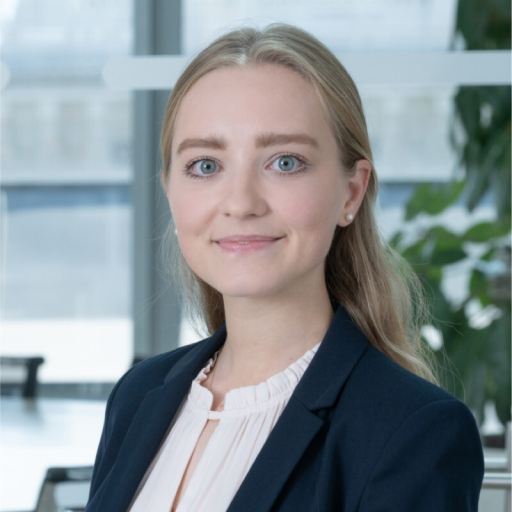

In [15]:
import requests
# Url of my slack profile
url = "https://ca.slack-edge.com/TUTJQ5RNV-U02P1ET637V-7d91d73a4fd4-512"
#init_image = Image.open(requests.get(url, stream=True).raw)
# Or select a file in the /content/application_pictures/ folder
init_image = Image.open("/content/application_pictures/1_frau_blond_26.jpg")
display(init_image)

In [21]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler, EulerDiscreteScheduler
from IPython.display import display


MODEL_NAME = "/content/finetuned_model_checkpoint"

scheduler_euler = EulerDiscreteScheduler.from_pretrained(MODEL_NAME, subfolder="scheduler")
scheduler_ddim = DDIMScheduler.from_pretrained(MODEL_NAME,subfolder="scheduler")

# First for Euler
if PRECISION == "fp16":
  pipe = StableDiffusionDepth2ImgPipeline.from_pretrained(MODEL_NAME, scheduler=scheduler_ddim, safety_checker=None, torch_dtype=torch.float16).to("cuda")
else:
  pipe = StableDiffusionDepth2ImgPipeline.from_pretrained(MODEL_NAME, scheduler=scheduler_ddim, safety_checker=None, torch_dtype=torch.float32).to("cuda")

Keyword arguments {'safety_checker': None} are not expected by StableDiffusionDepth2ImgPipeline and will be ignored.


  0%|          | 0/57 [00:00<?, ?it/s]

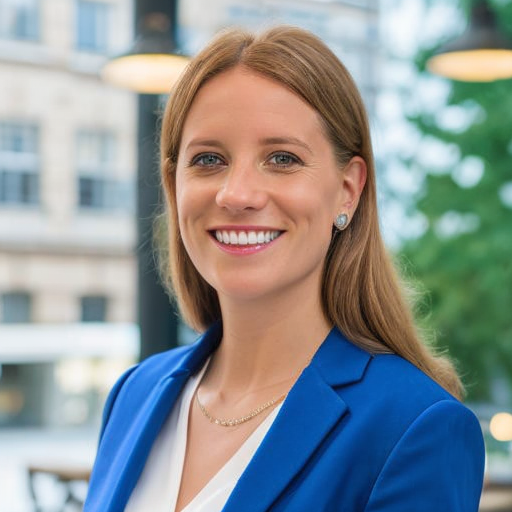

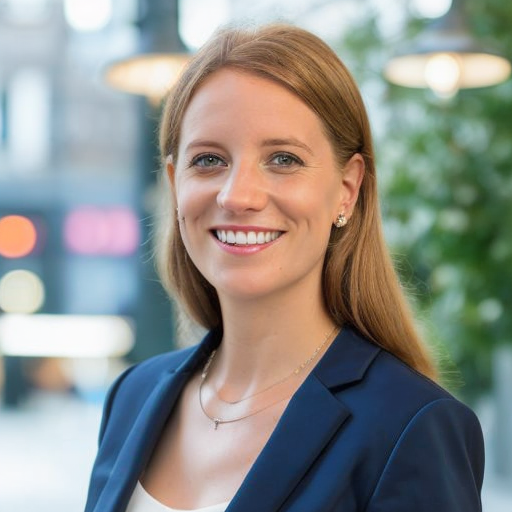

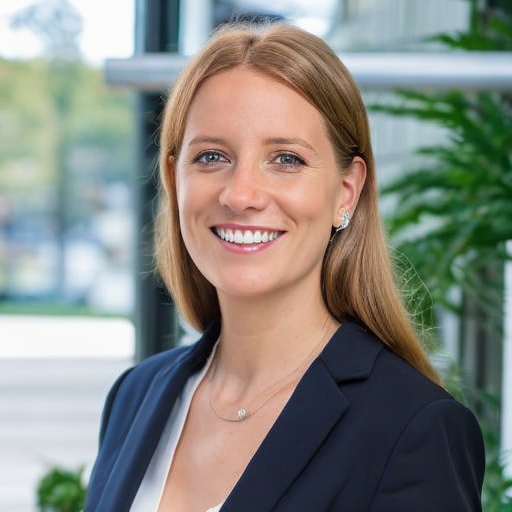

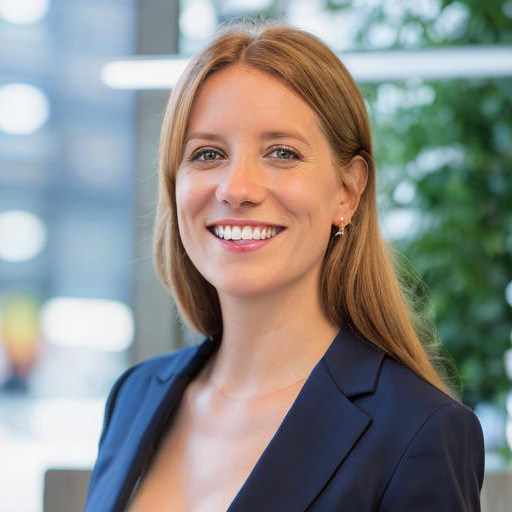

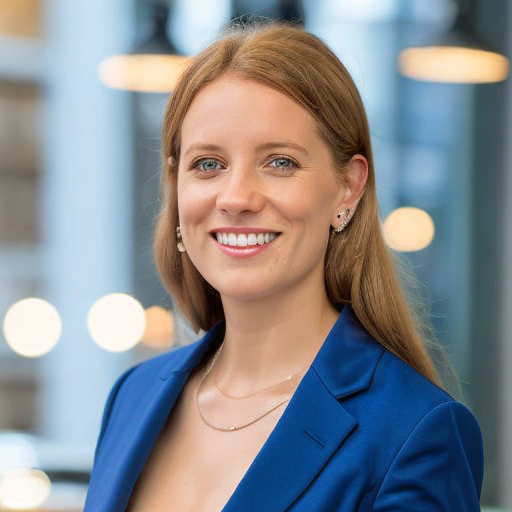

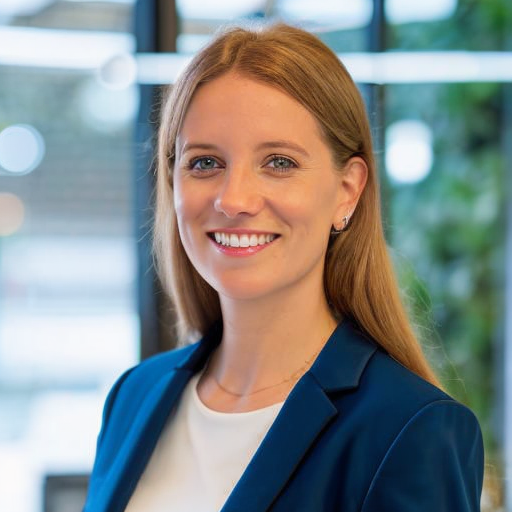

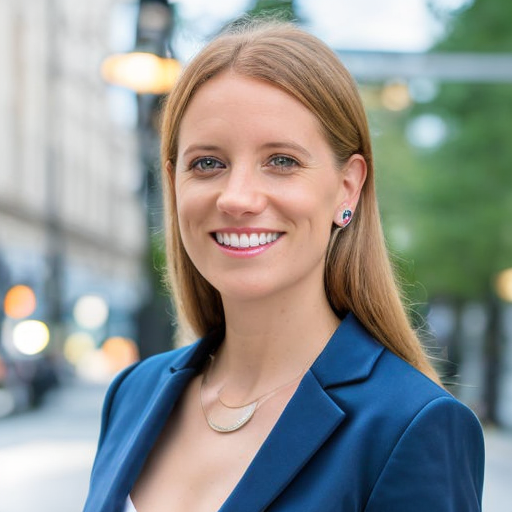

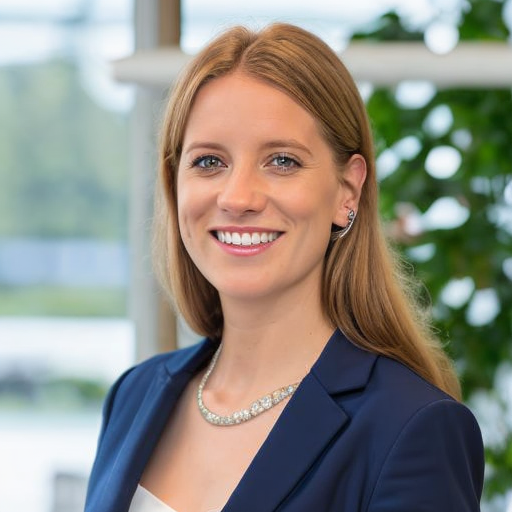

In [42]:
# Then for DDIM
g_cuda = torch.Generator(device='cuda').manual_seed(52362)

prompt = "Professional portrait photo of llisches woman in a Business Jacket, bokeh, studio lighting, HDR, UHD, 4K, 8k, 64K, highly detailed, portrait, 40mm lens, shallow depth of field, close up, studio lighting"
negative_prompt = "blender, ugly, different eye color, multiple hands, bad anatomy, bad proportions, unrealistic, full body, cropped, lowres, poorly drawn face, out of frame, poorly drawn hands, double, blurred, disfigured, deformed, repetitive, black and white"
guidance_scale = 6
num_inference_steps = 70
height = 512
width = 512
strength = 0.825

images = run_and_log_pipeline(pipe,
                              strength,
                              init_image,
                              prompt, 
                              negative_prompt, 
                              guidance_scale, 
                              num_inference_steps, 
                              height, 
                              width)
for image in images:
  display(image)

In [43]:
# Log the table to WANDB
run.log({"prompt_engineering": table_instance})

In [60]:
run.finish()

In [54]:
torch.save(pipe.unet.state_dict(), "/content/model.cpkt")

In [56]:
torch.save(pipe.text_encoder.state_dict(), "/content/textencoder.cpkt")

In [59]:
print("UNet model size: ", os.path.getsize("/content/model") >> 20)
print("Textencoder model size: ", os.path.getsize("/content/textencoder.cpkt") >> 20)

UNet model size:  1651
Textencoder model size:  649
